<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_stringer_orientations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/projects/neurons/load_stringer_orientations.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Loading of Stringer orientations data

includes some visualizations

In [2]:
# @title Install depedencies
# !pip install umap-learn --quiet
# don't run the install if you are on the ssh server
# simply choose the `umap-env` as your python interpreter and jupyter kernel

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from umap import UMAP

In [4]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [5]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [6]:
# @title Data loading

dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [7]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(23589, 4598)
23589


/tmp/ipykernel_21176/2885581141.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')(xc)


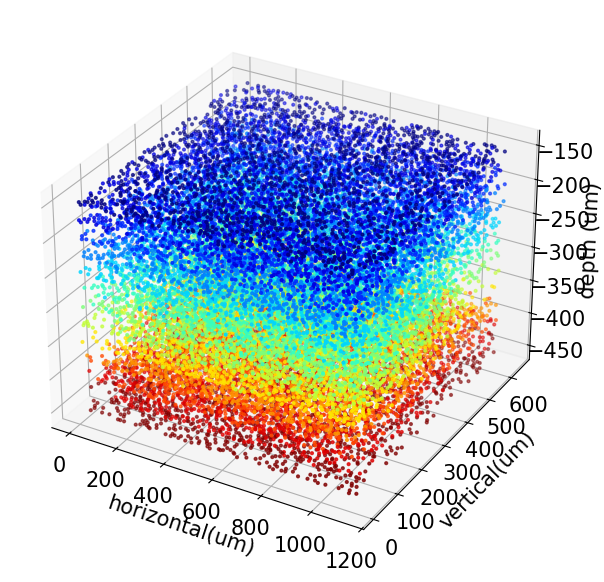

In [8]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

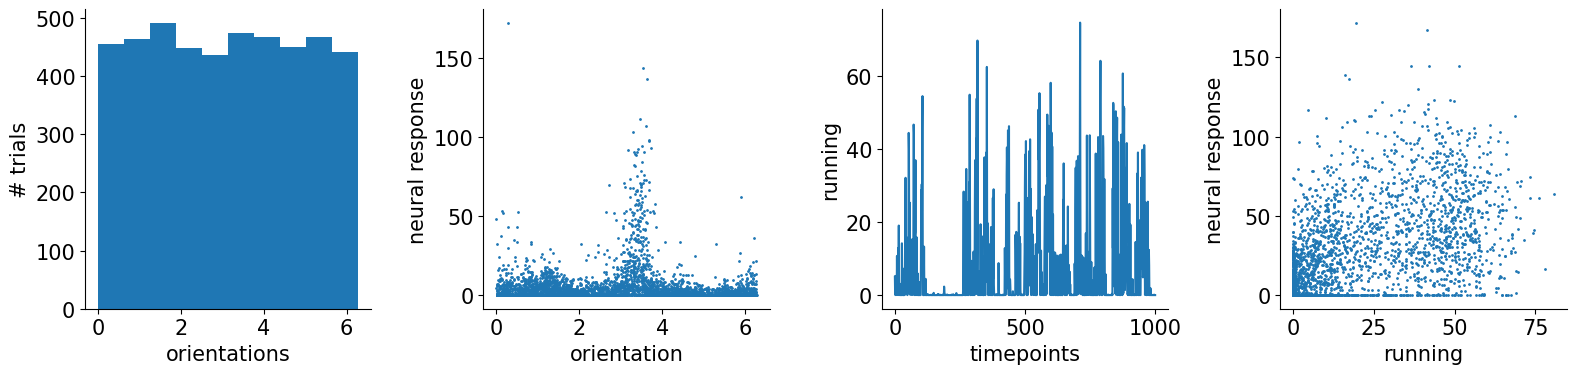

In [9]:
# @title Basic data properties using plot, hist and scatter
ax = plt.subplot(1, 5, 1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel='# trials')

ax = plt.subplot(1, 5, 2)
plt.scatter(dat['istim'], dat['sresp'][1000], s=1)
ax.set(xlabel='orientation', ylabel='neural response')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['run'][:1000])
ax.set(xlabel='timepoints', ylabel='running')

ax = plt.subplot(1, 5, 4)
plt.scatter(dat['run'], dat['sresp'][20998], s=1)
ax.set(xlabel='running', ylabel='neural response')

plt.show()

In [ ]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
X = PCA(n_components=200).fit_transform(Z.T)

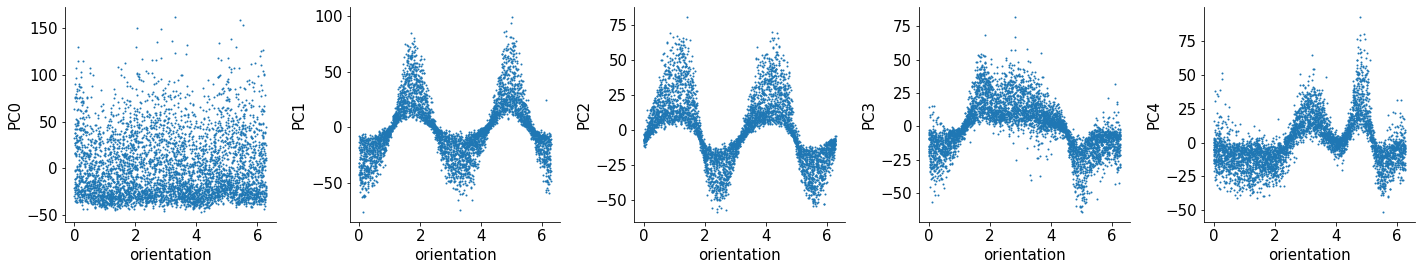

In [ ]:
# @title plot PCs as function of stimulus orientation
for j in range(5):
  ax = plt.subplot(1, 5, j + 1)
  plt.scatter(dat['istim'], X[:, j], s=1)
  ax.set(xlabel='orientation', ylabel='PC%d'%j)
plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


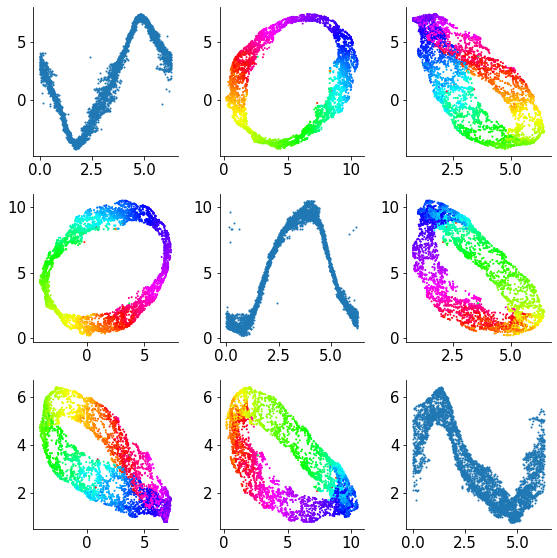

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(dat['istim'], embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=dat['istim'], cmap='hsv')
plt.show()

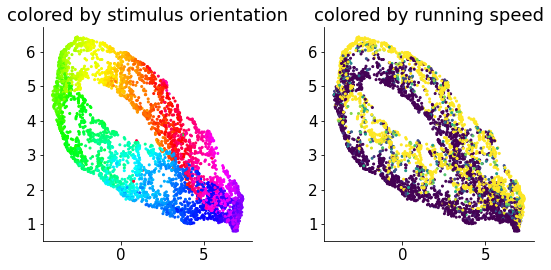

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 0], embed[:, 2], s=4, c=dat['istim'], cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 0], embed[:, 2], s=4, c=dat['run'], vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()